In [1]:
import numpy as np 
import pandas as pd 

import torch

from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv("data.csv", index_col="index")
data

,title,genre,summary
index,,,
0,Drowned Wednesday,fantasy,Drowned Wednesday is the first Trustee among ...
1,The Lost Hero,fantasy,"As the book opens, Jason awakens on a school ..."
2,The Eyes of the Overworld,fantasy,Cugel is easily persuaded by the merchant Fia...
3,Magic's Promise,fantasy,The book opens with Herald-Mage Vanyel return...
4,Taran Wanderer,fantasy,Taran and Gurgi have returned to Caer Dallben...
...,...,...,...
4652,Hounded,fantasy,"Atticus O’Sullivan, last of the Druids, lives ..."
4653,Charlie and the Chocolate Factory,fantasy,Charlie Bucket's wonderful adventure begins wh...
4654,Red Rising,fantasy,"""I live for the dream that my children will be..."


<Axes: >

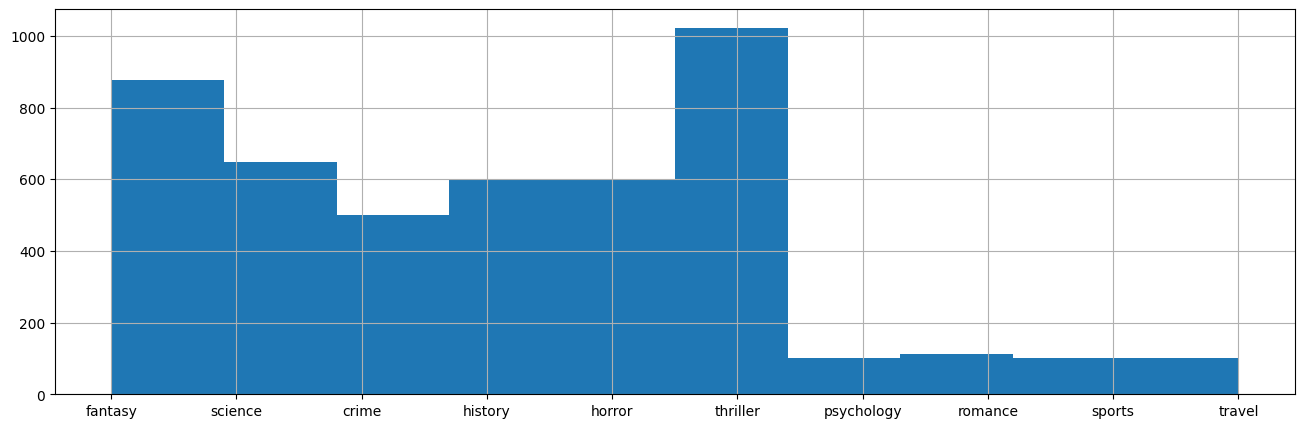

In [3]:
data.genre.hist(figsize=(16,5))

In [4]:
num_labels = len(data.genre.unique())
print("num labels: ", num_labels)
genre2id = {genre: i for i, genre in enumerate(data.genre.unique())}
id2genre = {i: genre for i, genre in enumerate(data.genre.unique())}

num labels:  10


<Axes: >

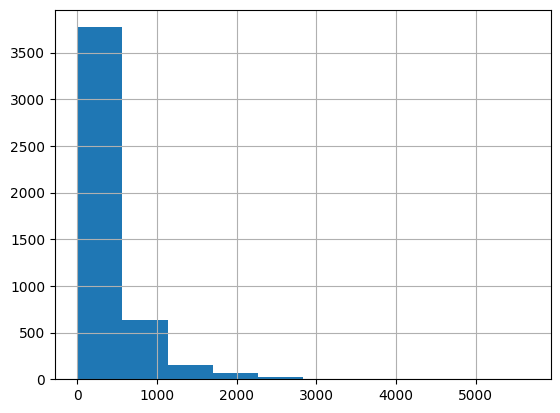

In [5]:
data.summary.str.split().apply(len).hist()

In [6]:
data["genre_id"] = data.genre.apply(lambda a: genre2id[a])

In [7]:
data["title_and_summary"] = data.apply(lambda a: a["title"] + "." + a["summary"], axis=1)
data["title_and_summary"]

index
0       Drowned Wednesday. Drowned Wednesday is the fi...
1       The Lost Hero. As the book opens, Jason awaken...
2       The Eyes of the Overworld. Cugel is easily per...
3       Magic's Promise. The book opens with Herald-Ma...
4       Taran Wanderer. Taran and Gurgi have returned ...
                              ...                        
4652    Hounded.Atticus O’Sullivan, last of the Druids...
4653    Charlie and the Chocolate Factory.Charlie Buck...
4654    Red Rising."I live for the dream that my child...
4655    Frostbite.Rose loves Dimitri, Dimitri might lo...
4656    Radiance.The Prince of no value\nBrishen Khask...
Name: title_and_summary, Length: 4657, dtype: object

BERT

In [8]:
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [9]:
!pip install transformers

In [10]:
from transformers import RobertaConfig

# Initializing a RoBERTa configuration
configuration = RobertaConfig()

configuration.num_labels = num_labels

In [11]:
from transformers import AdamW, BertConfig
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("roberta-base", max_length = 512)

model = AutoModelForSequenceClassification.from_pretrained(
    "roberta-base", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = num_labels, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    #output_attentions = False, # Whether the model returns attentions weights.
    #output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.

model.to(device)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [12]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []


# For every sentence...
for sent in data.title_and_summary.values:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 500,           # Pad & truncate all sentences.
                        truncation=True,
                        pad_to_max_length = True,
                        padding='max_length',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

labels = torch.tensor(data.genre_id.values)

In [13]:
print('Original: ', data.title_and_summary[0])
print('Token IDs:', input_ids[0])

Original:  Drowned Wednesday. Drowned Wednesday is the first Trustee among the Morrow Days who is on Arthur's side and wishes the Will to be fulfilled. She appears as a leviathan/whale and suffers from Gluttony. The book begins when Leaf is visiting Arthur and they are discussing the invitation that Drowned Wednesday sent him. Arthur had been admitted to hospital because of the damage done to his leg when he attempted to enter Tuesday's Treasure Tower. Suddenly, the hospital room becomes flooded with water as the two are transported to the Border Sea of the House. Leaf is snatched away by a large ship with green sails, known as the Flying Mantis, while Arthur remains in his bed. When the Medallion given him by the immortal called the Mariner apparently fails to summon help, Arthur is without hope. Eventually, a buoy marking the pirate Elishar Feverfew's treasure floats toward him. As soon as Arthur opens it, his hand is marked with a bloody red colour. Arthur now has the Red Hand, by w

In [14]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.85 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

3,958 training samples
  699 validation samples


In [15]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 16

train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size 
        )

valid_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset), 
            batch_size = batch_size 
        )


In [16]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [17]:
from transformers import get_linear_schedule_with_warmup

epochs = 3
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

In [18]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [19]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [24]:
import random
import numpy as np

from ignite.metrics import Precision, Recall

precision = Precision(average=False)

def train_model(model, train_dataloader, validation_dataloader):


    # Set the seed value all over the place to make this reproducible.
    seed_val = 42

    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    training_stats = []

    # Measure the total training time for the whole run.
    total_t0 = time.time()

    batch_loss = 0

    for epoch_i in range(0, epochs):


        # Training

        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        # Measure how long the training epoch takes.
        t0 = time.time()

        # Reset the total loss for this epoch.
        total_train_loss = 0

        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):


            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            model.zero_grad()        

            res = model(b_input_ids, 
                                 token_type_ids=None, 
                                 attention_mask=b_input_mask, 
                                 labels=b_labels)
            loss = res['loss']
            logits = res['logits']

            total_train_loss += loss.item()
            batch_loss += loss.item()

            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()

            # Update the learning rate.
            scheduler.step()

        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloader)            

        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epcoh took: {:}".format(training_time))


        # Validation

        print("")
        print("Running Validation...")

        t0 = time.time()

        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        model.eval()

        # Tracking variables 
        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0

        # Evaluate data for one epoch
        for batch in validation_dataloader:

            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)


            with torch.no_grad():        
                res = model(b_input_ids, 
                                       token_type_ids=None, 
                                       attention_mask=b_input_mask,
                                       labels=b_labels)
            loss = res['loss']
            logits = res['logits']

            # Accumulate the validation loss.
            total_eval_loss += loss.item()

            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            total_eval_accuracy += flat_accuracy(logits, label_ids)



        # Report the final accuracy for this validation run.
        avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
        print("  Accuracy: {0:.2f}".format(avg_val_accuracy))


        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(validation_dataloader)

        # Measure how long the validation run took.
        validation_time = format_time(time.time() - t0)

        print("  Validation Loss: {0:.2f}".format(avg_val_loss))
        print("  Validation took: {:}".format(validation_time))

        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. Accur.': avg_val_accuracy,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )

    print("")
    print("Training complete!")

    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
    
train_model(model, train_dataloader, valid_dataloader)


======== Epoch 1 / 3 ========
Training...


Results

In [ ]:
# train predictions

predictions = []
labels = []
for batch in train_dataloader:

    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)


    with torch.no_grad():        
        res = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        logits = res['logits']
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        labels.append(label_ids)
        predictions.append(logits)
        #print(logits)
            
flat_predictions = np.concatenate(predictions, axis=0)
flat_labels = np.concatenate(labels, axis=0).flatten()

flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

flat_labels.shape, flat_predictions.shape

In [ ]:
from sklearn.metrics import classification_report

print("Train data classification report")
target_names = data.genre.unique()
print(classification_report(flat_labels, flat_predictions, target_names=target_names))

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print("Train confusion matrix")

plt.figure(figsize=(13,13))
ax= plt.subplot()
cm = confusion_matrix(flat_labels, flat_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(ax=ax)

In [ ]:
# valid predictions

predictions = []
labels = []
for batch in valid_dataloader:

    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)


    with torch.no_grad():        
        res = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        logits = res['logits']
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        labels.append(label_ids)
        predictions.append(logits)
        #print(logits)
            
flat_predictions = np.concatenate(predictions, axis=0)
flat_labels = np.concatenate(labels, axis=0).flatten()

flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

flat_labels.shape, flat_predictions.shape

In [ ]:
print("Valid data classification report")
target_names = data.genre.unique()
print(classification_report(flat_labels, flat_predictions, target_names=target_names))

In [ ]:
print("Valid confusion matrix")

plt.figure(figsize=(13,13))
ax = plt.subplot()
cm = confusion_matrix(flat_labels, flat_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(ax=ax)